# Задача
Построить скоринговую модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

# Импорт библиотек и данных для работы

In [2]:
# необходимые библиотеки
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'"""
import warnings
warnings.simplefilter('ignore')

In [2]:
# исходные данные
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# функции
# функция подсчета количества выбросов
def get_outliers(column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    min_out = perc_25 - 1.5 * IQR
    max_out = perc_75 + 1.5 * IQR
    print('Всего выбросов: {} '.format(
        df[df[column] > max_out][column].count()+df[df[column] < min_out][column].count()))

# функция логарифмирования
def log_values(x):
    if x > 0: #логарифмирование применяется только к положительным числам
        x = np.log((x)+1)
    return x


In [4]:
print("Пропуски в тренировочной выборке:", df_train.isnull().sum(), sep ='\n')
print("Пропуски в тестовой выборке:", df_test.isnull().sum(), sep ='\n')

Пропуски в тренировочной выборке:
client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64
Пропуски в тестовой выборке:
client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64


In [5]:
# первичный осмотр
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(5))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(5))
# в тестовом датасете отсутствует признак default

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
# объединяем тренировочные и тестовые данные в один датасет
df_train['train'] = 1 # помечаем тренировочные
df_test['train'] = 0 # помечаем тестовые
df = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
df.info()
# данные отсутствуют в небольшом количестве по признаку education
# также стоит решить что делать с пропусками в столбце default, возникшие после объединения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
# используем модуль для быстрого первичного анализа данных
#pandas_profiling.ProfileReport(df)

Краткий итог: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 признаков, из них 1 - дата, который стоит обработать в самом начале. Все пропуски имеются  в признаке education. Пропуски в признаке default появились исскуственно. Также добавился признак Train для обозначения принадлежности данных и последующего разделения.

# Предобработка

In [9]:
# избавимся от пропущенных значений, учитывая что данные в столбце education - 
# категориальные, заменим на моду.
# хотя можно создать еще одну категорию - отсутствие данных
df.education = df.education.apply(
    lambda x: df.education.mode()[0] if pd.isna(x) == True else x)

In [10]:
# проведем ту же процедуру с default, хотя это и не обязательно
df.default = df.default.apply(
    lambda x: df.default.mode()[0] if pd.isna(x) == True else x)

In [11]:
# проверим
print(df.isna().sum())
print(df.info())

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
train               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7  

In [12]:
# проведем работу с признаком app_date
# сконвертируем формат даты к удобному для работы
df.app_date = pd.to_datetime(df.app_date)
display(df.app_date.sample(5))

31863   2014-02-24
28683   2014-04-09
91761   2014-02-04
96796   2014-02-04
8431    2014-02-26
Name: app_date, dtype: datetime64[ns]

In [13]:
# Выясняем начало и конец периода нашего датасета
# Вероятно все данные только за 2014 год
print("Начало:", df.app_date.min(), "Конец:", df.app_date.max())

Начало: 2014-01-01 00:00:00 Конец: 2014-04-30 00:00:00


In [14]:
# создадим простые новые признаки на основе даты
df['app_day'] = df.app_date.dt.day
df['app_month'] = df.app_date.dt.month
df['app_year'] = df.app_date.dt.year
df["app_weekday"] = df["app_date"].dt.weekday

# также создадим признак количества прошедших дней с момента начала наблюдений,
# т.е. с 1 января 2014 года
df["app_number_days"] = (df["app_date"] - df.app_date.min()).dt.days.astype('int')

In [15]:
# проверим действительно ли данные только за 2014 год
print(df.app_year.unique())

[2014]


In [16]:
# удалим ненужные столбцы app_year и app_date
df.drop(["app_date", "app_year"], axis=1, inplace=True)

<AxesSubplot:>

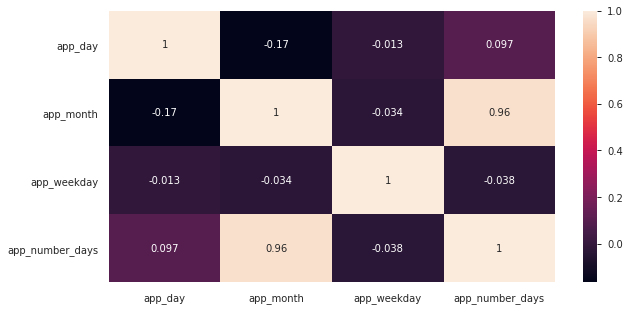

In [17]:
# проверим по матрице корреляций нет ли избыточных признаков
plt.figure(figsize=(10,5))
sns.heatmap(df.iloc[:,19:].corr(), annot=True)
# можно удалить признак app_month т.к. он имеет высокую корреляцию с app_number_days

In [18]:
df.drop(["app_month"], axis=1, inplace=True)

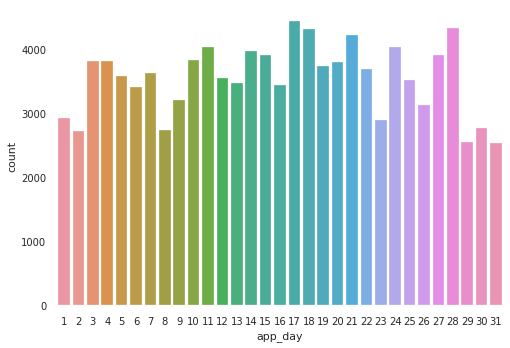

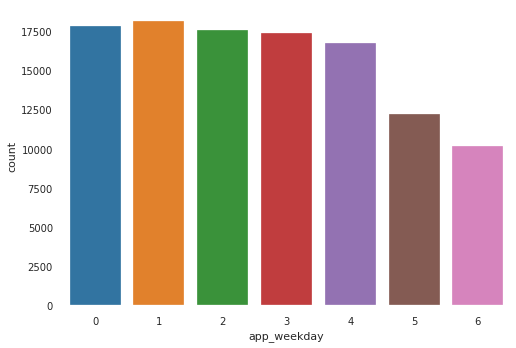

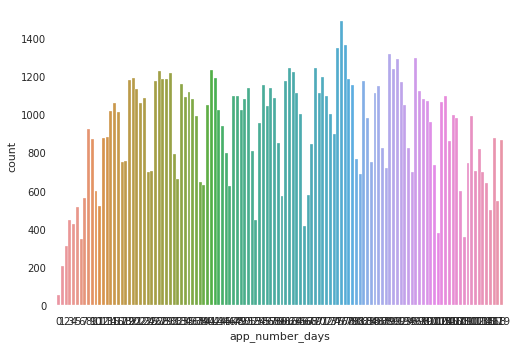

In [19]:
# посмотрим на распределение данных, оставим так для модели
for i in df.iloc[:,19:].columns:
    sns.countplot(x = df[i], data = df)
    plt.show()

In [20]:
# для удобства разобьем признаки на списки
# числовые
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income", "app_day", "app_weekday", "app_number_days"]

# бинарные, количество уникальных значений которых равно двум
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = ["education", "region_rating",
            "home_address", "work_address", "sna", "first_time"]
# client_id исключен, он имеет уникальные значения, возможно его стоит удалить
# default и train также исключены из списков

**Работа с числовыми признаками**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


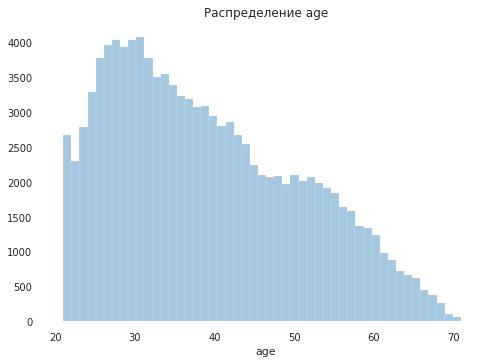

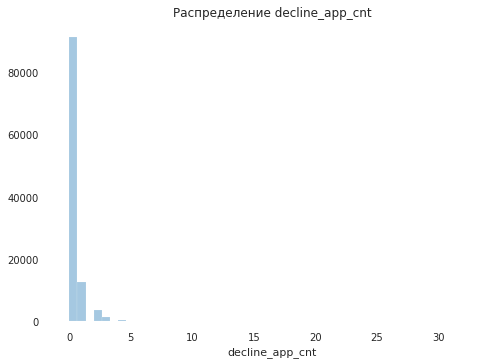

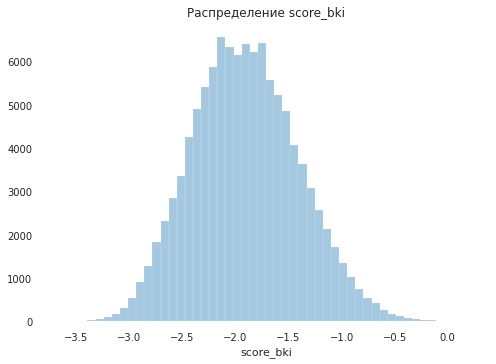

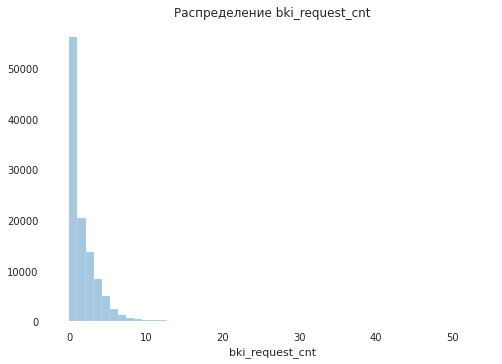

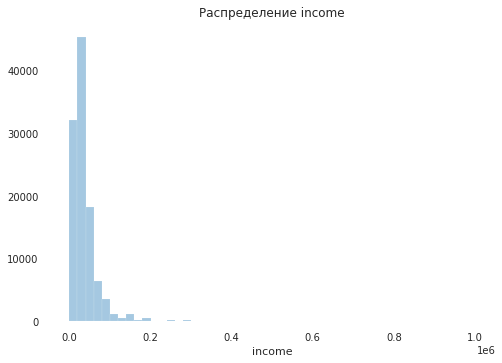

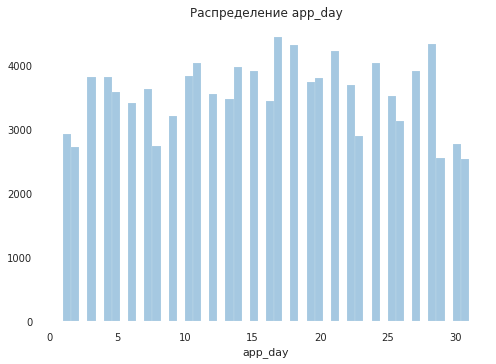

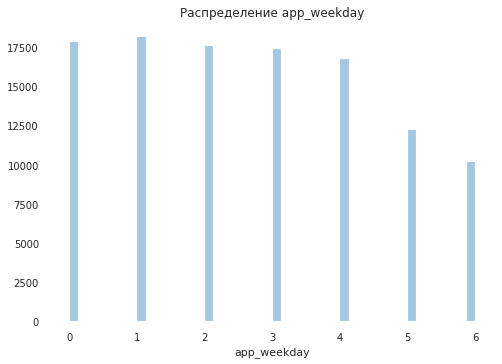

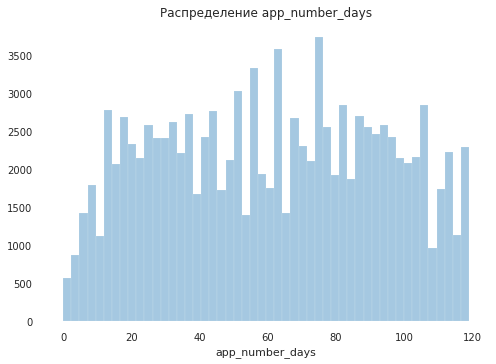

In [23]:
# анализ распределения числовых переменных с помощью визуализации
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)
# признаки age, decline_app_cnt, bki_request_cnt и income стоит логарифмировать

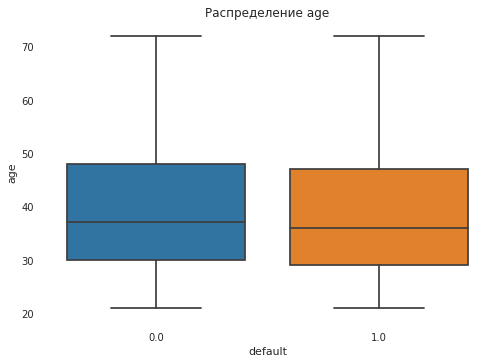

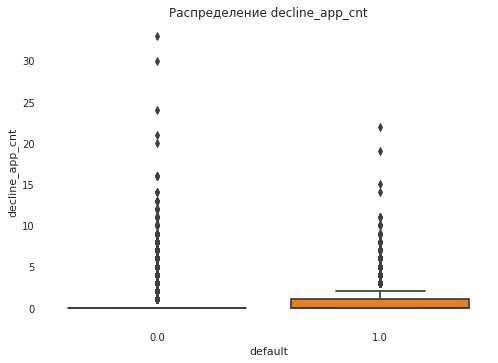

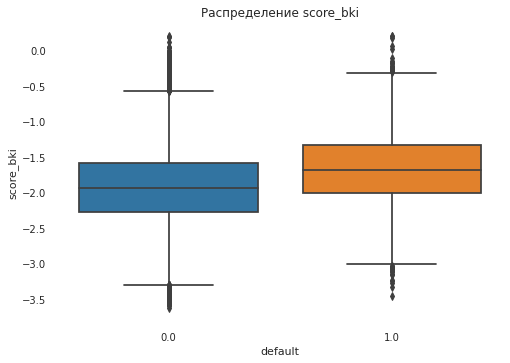

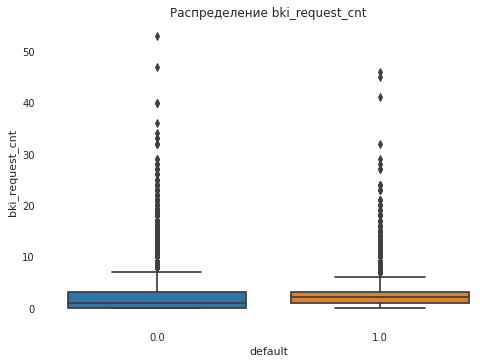

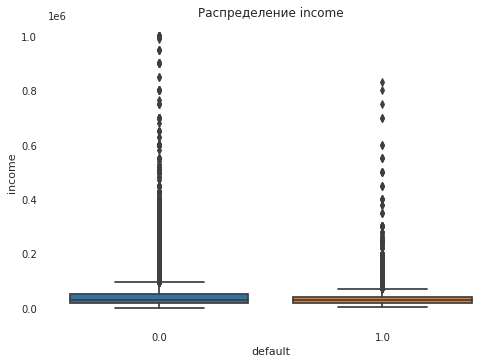

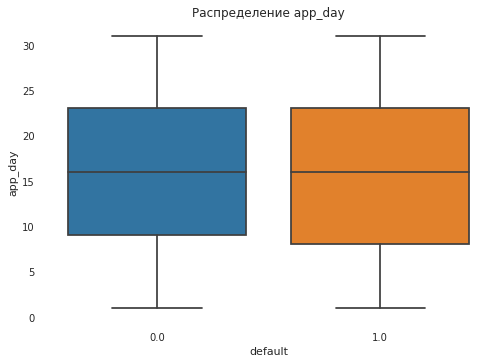

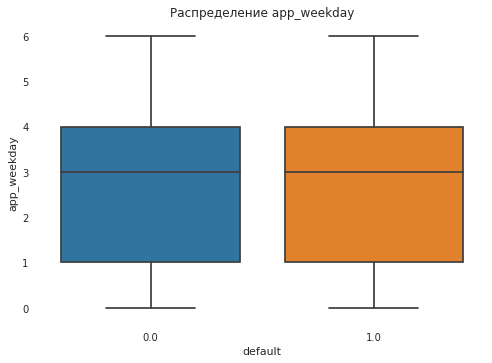

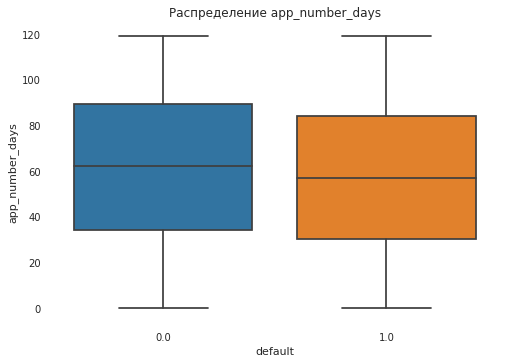

In [25]:
# посмотрим на выбросы с помощью боксплотов
# стоит обратить внимание на decline_app_cnt, score_bki, bki_request_cnt
# в столбцу income это вероятно не выбросы, а просто хорошие доходы
for col in num_cols:
    plt.title(f"Распределение {col}")
    sns.boxplot(x='default',y = col,data=df)
    plt.show()

In [26]:
# узнаем количество выбросов до обработки
print(get_outliers(['decline_app_cnt']))
print(get_outliers(['income']))
print(get_outliers(['bki_request_cnt']))

Всего выбросов: decline_app_cnt    18677
dtype: int64 
None
Всего выбросов: income    7000
dtype: int64 
None
Всего выбросов: bki_request_cnt    2636
dtype: int64 
None


In [27]:
# прежде чем работать с выбросами, проведем логарифмирование
df['income'] = df.income.apply(log_values)
df['age'] = df.age.apply(log_values)
df['bki_request_cnt'] = df.bki_request_cnt.apply(log_values)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>,
        <AxesSubplot:title={'center':'score_bki'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'app_day'}>],
       [<AxesSubplot:title={'center':'app_weekday'}>,
        <AxesSubplot:title={'center':'app_number_days'}>, <AxesSubplot:>]],
      dtype=object)

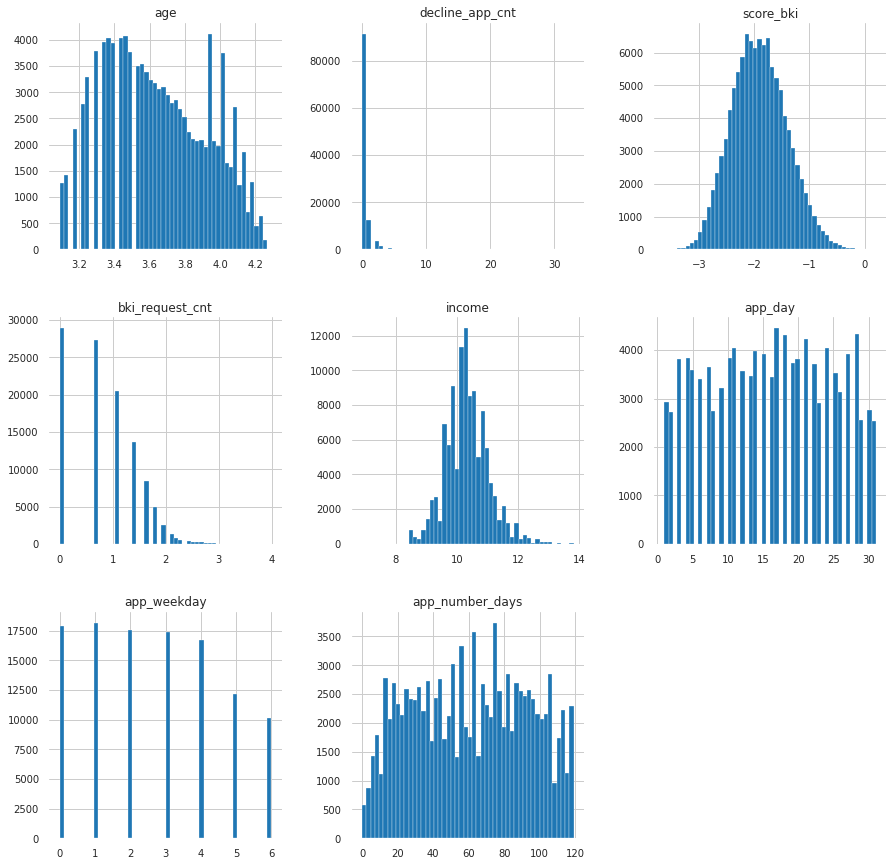

In [28]:
# распределение после логарифмирования
df[num_cols].hist(
    figsize=(15, 15), bins=50)

In [29]:
# узнаем количество выбросов после обработки
print(get_outliers(['decline_app_cnt']))
print(get_outliers(['income']))
print(get_outliers(['bki_request_cnt']))

Всего выбросов: decline_app_cnt    18677
dtype: int64 
None
Всего выбросов: income    2609
dtype: int64 
None
Всего выбросов: bki_request_cnt    15
dtype: int64 
None


Мы провели успешную работу по логарифмированию необходимых признаков, что также положительно повлияло на количестов выбросов в этих признаках.
Выводы:
* Дефолтные клиенты в среднем младше
* Дефолтные клиенты в среднем имеют большое количество отмененных заявок
* Дефолтные клиенты в среднем имеют больше запросов в БКИ
* Дефолтные клиенты в среднем имеют меньший доход

Дальнейшие действия:
* Ничего не будем делать с выбросами в признаках income и score_bki (потому что это, вероятно, полезные выбросы)
* Переведем в категориальный признак decline_app_cnt и параллельно избавимся от выбросов

In [30]:
#Посмотрим на распределение decline_app_cnt
df.decline_app_cnt.value_counts()
# большую часть значений принимает 0(значит,отказов раньше не было)

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

In [31]:
# делаем признак категориальным
# все значения прошлых отказов более 3 приравниваем к 3
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: x if x < 3 else 3)

In [32]:
# внесем изменения в списки
num_cols.remove("decline_app_cnt")
cat_cols.append('decline_app_cnt')

<AxesSubplot:>

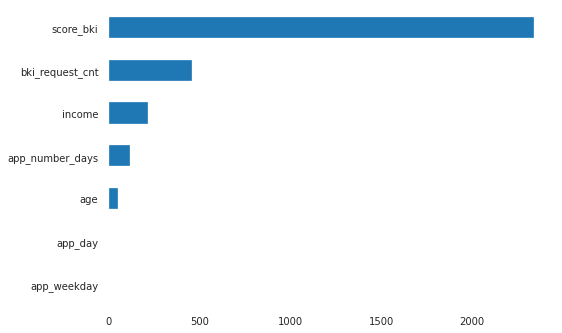

In [33]:
# проверим значимость числовых переменных
# используем функцию  однофакторный дисперсионный анализ (ANOVA) для оценки:
temp_df = df[df['train']==1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Выводы:
самый значимый признак score_bki - скоринговый балл по данным из БКИ
возможно стоит удалить признаки app_day и app_weekday
решим это после проведения дальнейших исследований

<AxesSubplot:>

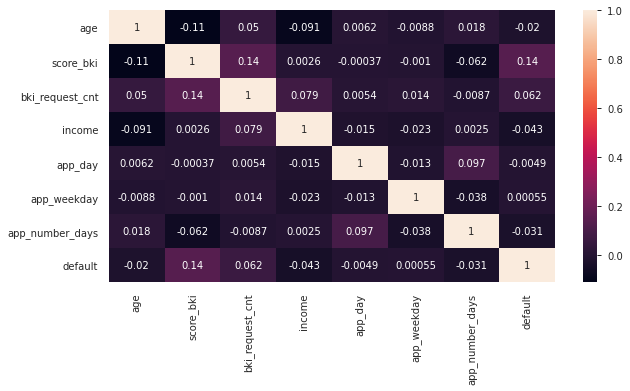

In [34]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols+['default']].corr(), annot=True)
# матрица подтверждает сделанные ранее выводы
# в целом данные подходят для включения в модель

**Работа с бинарными признаками**

In [35]:
# преобразование с помощью LabelEncoder()
label_encoder = LabelEncoder()
# перед кодировкой зафиксируем маркировку значений
for i in bin_cols:
    mapped = pd.Series(label_encoder.fit_transform(df[i]))
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


In [36]:
# преобразование с помощью LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_weekday,app_number_days
0,25905,SCH,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,1,1,5,31
1,63161,SCH,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,1,12,2,70
2,25887,SCH,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,1,1,5,31
3,16222,SCH,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,1,23,3,22
4,101655,GRD,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,1,18,4,107


In [37]:
# еще раз проверим и посмотрим как распределяются данные
# интересный момент - женщины чаще обращаются за кредитами чем мужчины
for i in bin_cols:
    display(df[i].value_counts())

0    61836
1    48312
Name: sex, dtype: int64

0    74290
1    35858
Name: car, dtype: int64

0    89140
1    21008
Name: car_type, dtype: int64

0    91917
1    18231
Name: good_work, dtype: int64

0    93721
1    16427
Name: foreign_passport, dtype: int64

интересная зависимость между признаками car и car_type. Вообще признак car_type неоднозначный: отсутствие флага иномарки также видимо означает и отсутствие автомобиля в принципе. Логично также зависимость между наличием иномарки и заграничного паспорта.

<AxesSubplot:>

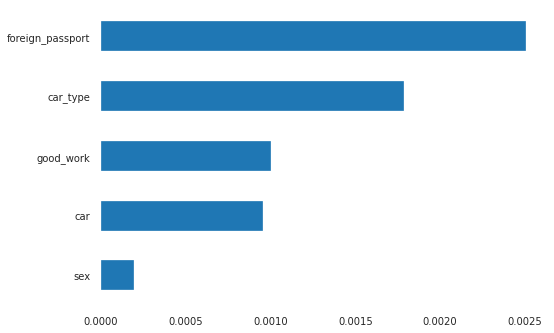

In [38]:
# Проверим значимость бинарных переменных:
temp_df = df[df['train']==1]
imp_bin = Series(mutual_info_classif(temp_df[bin_cols], temp_df['default'],
                                     discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

Вывод: все признаки имеют значение, удивительно и даже немного нелогично, что наличие иномарки имеет большее влияние, чем хорошая работа.

**Работа с категориальными признаками**

In [39]:
# преобразуем данные признака education в числовые категории
mapped = pd.Series(label_encoder.fit_transform(df['education']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [40]:
df['education'] = label_encoder.fit_transform(df['education'])
df.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_weekday,app_number_days
35624,33336,4,1,3.496508,1,1,0,0,-1.404442,1.098612,50,1,2,10.203629,1,3,0,0.0,1,9,6,39
16981,16231,1,1,4.043051,0,0,0,1,-2.605323,0.693147,60,2,3,10.725490,1,3,0,1.0,1,23,3,22
102151,85370,3,0,4.077537,0,0,0,1,-1.438874,0.693147,50,2,3,10.126671,1,4,0,0.0,0,2,2,91


<AxesSubplot:>

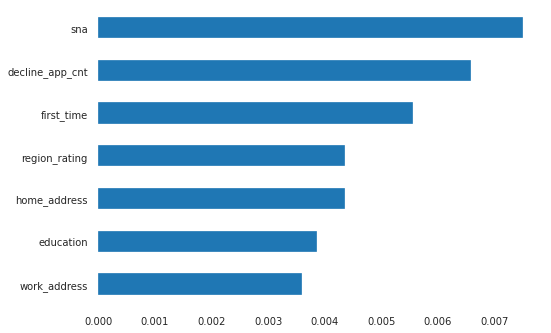

In [41]:
# Проверим значимость категориальных переменных:
temp_df = df[df['train']==1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols], temp_df['default'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Вывод: влияние признаков выглядит логично, все признаки имеют значение, не будем удалять.

# Future Engeneering

In [42]:
# реализуем OneHotEncoding для категориальных признаков
df = pd.get_dummies(df, columns = cat_cols)

In [43]:
# удалим ненужные переменные
num_cols.remove('app_day')
num_cols.remove('app_weekday')
df.drop(['app_day', 'app_weekday'], axis=1, inplace=True)

In [44]:
df

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,app_number_days,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3
0,25905,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,0.0,1,31,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,63161,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,0.0,1,70,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
2,25887,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,1,0.0,1,31,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,16222,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,0,0.0,1,22,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
4,101655,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,1,0.0,1,107,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,3.637586,0,0,0,-1.744976,1.386294,9.615872,0,0.0,0,89,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0
110144,106254,0,4.174387,1,1,0,-2.293781,1.386294,12.206078,0,0.0,0,114,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
110145,81852,1,3.465736,0,0,0,-0.940752,0.693147,11.002117,0,0.0,0,88,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
110146,1971,0,3.332205,0,0,0,-1.242392,1.098612,10.308986,0,0.0,0,6,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0


In [45]:
# добавим новые полиномиальные признаки, 
# которые являются мат. комбинациями числовых признаков
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df,  how='left')

In [46]:
df.head()

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,train,app_number_days,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,25905,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,0.0,1,31,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,17.165565,-8.322534,2.871802,40.595191,128.437177,4.035088,-1.392361,-19.682128,-62.271341,0.480453,6.791583,21.487563,96.004382,303.743660,961.0
1,63161,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,0.0,1,70,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,16.763657,-6.273667,5.675967,40.338493,286.604119,2.347870,-2.124186,-15.096364,-107.259335,1.921812,13.658114,97.040605,97.066769,689.657282,4900.0
2,25887,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,1,0.0,1,31,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,10.615193,-4.587863,2.258340,33.587672,101.000993,1.982865,-0.976050,-14.516519,-43.652410,0.480453,7.145645,21.487563,106.275192,319.578566,961.0
3,16222,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,0,0.0,1,22,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,15.911994,-8.207220,4.382347,36.740300,87.757649,4.233188,-2.260363,-18.950217,-45.264369,1.206949,10.118703,24.169470,84.832212,202.629688,484.0
4,101655,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,1,0.0,1,107,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,15.146265,-4.844237,2.697604,40.120721,416.424772,1.549335,-0.862776,-12.831829,-133.185333,0.480453,7.145645,74.166748,106.275192,1103.061501,11449.0


# Построение модели

In [47]:
def count_metrics(y_test, y_pred, y_proba):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

In [48]:
# разбиваем выборку по индикаторы в признаке train
df_train = df.query('train == 1').drop(['train'], axis=1)
df_test = df.query('train == 0').drop(['train'], axis=1)

In [49]:
# проверим на соответствие значений
print("Тренировочная выборка:", df_train.shape,
      "Тестовая выборка:", df_test.shape, sep='\n')
# количество строк соответствует исходным

Тренировочная выборка:
(73799, 57)
Тестовая выборка:
(36349, 57)


In [50]:
# еще раз делим тренировочные данные на тестовую и валидационную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

**Модель 1. Простая**

In [51]:
# проведем обучения на данной простой модели
model_1 = LogisticRegression(solver = 'liblinear')
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
y_proba = model_1.predict_proba(X_test)[:,1]

In [52]:
# оценка качества
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))
# низкие показатели f1 говорят о том, что у наc проблемы

accuracy_score: 0.8762
f1_score: 0.0011
recall_score: 0.0005
MSE: 0.1238


In [53]:
#Посмотрим на Сonfusion Matrix
confusion_matrix(y_test, y_pred)
# выглядит как переобученная модель

array([[12931,     2],
       [ 1826,     1]])

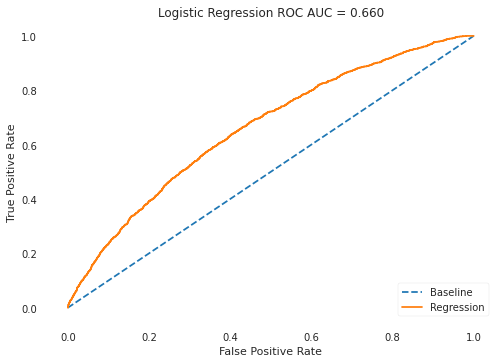

In [54]:
#Cтроим ROC AUС


fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Модель 2. Oversampling**

<AxesSubplot:ylabel='Frequency'>

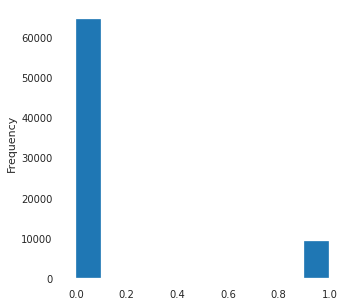

In [55]:
# Посмотрим на распределение целевого признака 'default':
df_train['default'].plot(kind = 'hist',figsize=(5,5)) 
#клиентов без дефолта в банке значительно больше

In [56]:
#Значение 0 явно преобладает и заметна несбалансированность в выборке, в таком случае модель склонна переобучаться.
#Попробуем применить в этом случае oversampling, чтобы сгладить эту разницу.
zeroes = df_train[df_train['default']==0]
ones = df_train[df_train['default']==1]
default_new = int(len(zeroes)/len(ones))
for i in range(default_new):
    df_train = df_train.append(ones).reset_index(drop=True) 

In [57]:
# еще раз делим тренировочные данные на тестовую и валидационную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [58]:
# проведем обучение
model_1 = LogisticRegression(solver = 'liblinear')
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
y_proba = model_1.predict_proba(X_test)[:,1]

In [59]:
# оценка качества
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6731
f1_score: 0.6785
recall_score: 0.6889
MSE: 0.3269


In [60]:
#Посмотрим на Сonfusion Matrix
confusion_matrix(y_test, y_pred)
# стоит признать, что модель после преобразования лучше, но стоит еще поработать

array([[8535, 4450],
       [4051, 8971]])

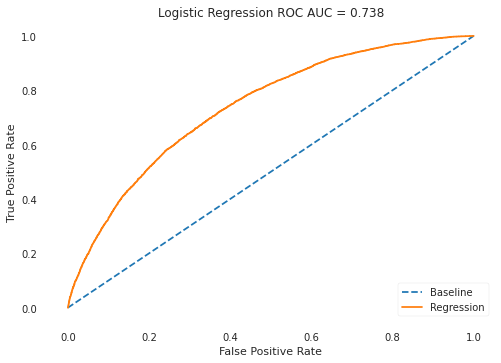

In [61]:
#Cтроим ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Модель 3. Нормализация и Oversampling**

In [62]:
#нормализация
df_train_balanced=df_train
num_cols_std = StandardScaler().fit_transform(df_train_balanced[num_cols].values)

# здесь старые данные уберем и заменим их на нормализованные
X = np.hstack([df_train_balanced.drop(num_cols + ['client_id','default'], axis=1), num_cols_std])
Y = df_train_balanced['default'].values

# Снова делим данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#проводим обучение 
model_std_balanced = LogisticRegression(solver = 'liblinear')
model_std_balanced.fit(X_train, y_train)
y_pred = model_std_balanced.predict(X_test)
y_proba = model_std_balanced.predict_proba(X_test)[:,1]

In [63]:
# оценка качества
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))
# низкие показатели f1 говорят о том, что у наc проблемы

accuracy_score: 0.6749
f1_score: 0.6797
recall_score: 0.6888
MSE: 0.3251


In [64]:
#Посмотрим на Сonfusion Matrix
confusion_matrix(y_test, y_pred)

array([[8582, 4403],
       [4052, 8970]])

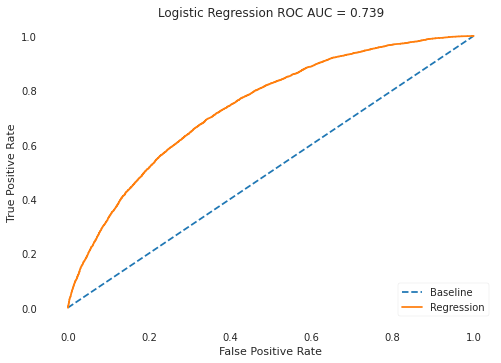

In [65]:
#Cтроим ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
# в целом показатели лучше, но незначительно

**Модель 4. С подбором параметров**

In [66]:
import warnings
warnings.simplefilter('ignore')

In [67]:
# функция по подбору лучших параметров
def regularise(X_train, y_train):
    C = np.logspace(0, 4, 10)
    penalty = ['l1', 'l2']
    hyperparameters = dict(C=C, penalty=penalty)
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    best_penalty = best_model.best_estimator_.get_params()['penalty']
    best_c = best_model.best_estimator_.get_params()['C']
    best_solver = best_model.best_estimator_.get_params()['solver']
    return best_penalty, best_c, best_solver

In [68]:
best_penalty, best_c, best_solver = regularise(X_train, y_train)
best_penalty, best_c, best_solver

('l2', 2.7825594022071245, 'lbfgs')

In [69]:
# посмотрим на модель с лучшими параметрами
model_finish = LogisticRegression(penalty='l2', C=2.7825594022071245, class_weight='balanced', max_iter=1000, solver = 'liblinear')
model_finish.fit(X_train, y_train)

y_pred = model_finish.predict(X_test)
y_proba = model_finish.predict_proba(X_test)[:,1]

In [70]:
# оценка качества
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))
# низкие показатели f1 говорят о том, что у наc проблемы

accuracy_score: 0.6744
f1_score: 0.6759
recall_score: 0.6782
MSE: 0.3256


In [71]:
#Посмотрим на Сonfusion Matrix
confusion_matrix(y_test, y_pred)

array([[8707, 4278],
       [4191, 8831]])

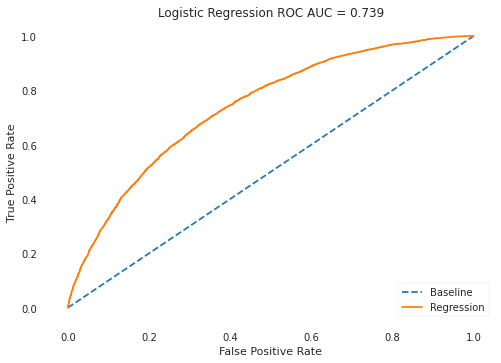

In [72]:
#Cтроим ROC AUС
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
# в целом показатели лучше, на этом остановимся

Вывод: мы провели ряд стандартных манипуляций по подбору модели обучения и ее лучших параметров. Это позволило получить достойные и стабильные на всех частях выборки, результаты.

# Submission

In [73]:
#расчет на отбалансированных тестовых данных
num_cols_std = StandardScaler().fit_transform(df_test[num_cols].values)
X_test = np.hstack([df_test.drop(num_cols + ['client_id','default'], axis=1), num_cols_std])
y_probs = model_finish.predict_proba(X_test)[:,1]
df_test['default'] = y_probs

In [74]:
submission = df_test[['client_id','default']]
submission.to_csv('sample_submission.csv', index=False)
submission.sample(3)
#submission.shape

,client_id,default
75908,5602,0.639341
82934,86286,0.684191
87266,4281,0.447634
